In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from functools import partial
import sys
from pathlib import Path

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMP import *
from src.causalKLGP import *
from src.kernels import *
from src.GP_utils import *
from src.kernel_utils import *
from src.dgps import *
from src.CBO import *

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/CBO.py:7: SyntaxWarning: invalid escape sequence '\h'
  """
/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/CBO.py:24: SyntaxWarning: invalid escape sequence '\h'
  """


In [2]:
# Getting inerventional data
n_int = 100
int_samples = 10**5
dostatin = torch.linspace(0,1,n_int)
age, bmi, aspirin, statin, cancer, psa = STATIN_PSA(int_samples, seed = 0, gamma = False, 
               interventional_data = True, dostatin=dostatin)
psa,fvol, vol = PSA_VOL(psa = psa)

In [3]:
# Drawing data with fixed statin, psa, bmi and age
age = torch.ones(n_int*int_samples)*45
bmi = torch.ones(n_int*int_samples)*25
aspirin = torch.ones(n_int*int_samples)*0.1
statin = dostatin.repeat_interleave(int_samples)
cancer = torch.sigmoid(2.2 - 0.05*age + 0.01*bmi - 0.04*statin + 0.02*aspirin)
psa = 5*Normal(6.8 + 0.04*age - 0.15*bmi - 0.60*statin + 0.55*aspirin + cancer, 0.4**0.5).sample()
psa,fvol, vol = PSA_VOL(psa = psa)

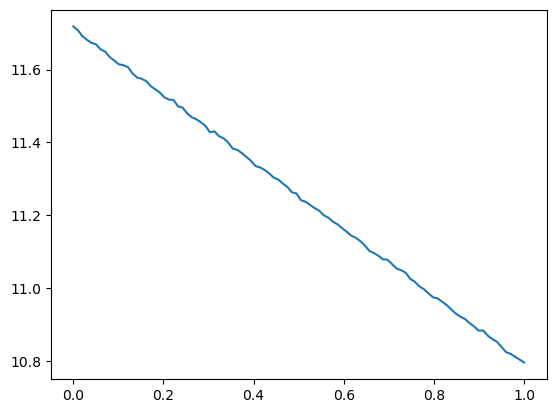

In [4]:
plt.plot(dostatin,fvol.reshape(n_int,int_samples).mean(1));

In [5]:
# Causal KL GP settings
retrain_hypers = False
sample_split = True,
marginal_loss = False
cal_nulist = 2**torch.linspace(-4,4,5)
niter = 1000
learn_rate = 0.1

samples = 500

In [6]:
# Getting training data
age_, bmi_, aspirin_, statin_, cancer_, psa_ = STATIN_PSA(samples, seed = 0, gamma = False, 
               interventional_data = False, dostatin=[])
psa_, fvol_, vol_ = PSA_VOL(psa = psa_)

# Training causalKLGP
A = torch.column_stack((age_, bmi_, aspirin_, statin_))
doA = torch.ones(len(dostatin), A.size()[1])
doA[:,0],doA[:,1],doA[:,2],doA[:,3] = 45,25,0.1, dostatin

V = psa_.reshape(len(psa_),1)
Y = vol_

model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5,
                   scale_V_init = Y.var()**0.5/2,
                   noise_Y_init = torch.log(Y.var()**0.5/2)
                  )
    
model.train(Y, A, V, niter, learn_rate, force_PD = True)

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/causalKLGP.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.noise_Y = torch.tensor(noise_Y_init, requires_grad = True).float()


iter 0 P(Y|V) loss:  tensor(2828.5439)
iter 100 P(Y|V) loss:  tensor(1451.8470)
iter 200 P(Y|V) loss:  tensor(1448.3093)
iter 300 P(Y|V) loss:  tensor(1446.6433)
iter 400 P(Y|V) loss:  tensor(1445.6780)
iter 500 P(Y|V) loss:  tensor(1445.0811)
iter 600 P(Y|V) loss:  tensor(1444.6823)
iter 700 P(Y|V) loss:  tensor(1444.4077)
iter 800 P(Y|V) loss:  tensor(1444.2091)
iter 900 P(Y|V) loss:  tensor(1444.0555)
iter 0 P(V|A) loss:  tensor(11148.7461)
iter 100 P(V|A) loss:  tensor(-5066.4180)
iter 200 P(V|A) loss:  tensor(-5166.5625)
iter 300 P(V|A) loss:  tensor(-5205.6641)
iter 400 P(V|A) loss:  tensor(-5224.9980)
iter 500 P(V|A) loss:  tensor(-5235.7578)
iter 600 P(V|A) loss:  tensor(-5242.1543)
iter 700 P(V|A) loss:  tensor(-5245.7891)
iter 800 P(V|A) loss:  tensor(-5248.0645)
iter 900 P(V|A) loss:  tensor(-5249.4082)


In [7]:
# Example functions to estimate \hat{E}[Y|do(X=x)] and \hat{Var}[\hat{E}[Y|do(X=x)]]
def estimate_mean(X):
    return torch.zeros(len(X),1) # Replace with actual estimation logic

def estimate_var(X):
    return torch.zeros(len(X),1)  # Replace with actual estimation logic

In [8]:
# Example functions to estimate \hat{E}[Y|do(X=x)] and \hat{Var}[\hat{E}[Y|do(X=x)]]
def estimate_mean(X):
    doA = X.reshape(len(X),1) @ torch.ones((1,len(A.T)))
    return model.post_mean(Y,A,V,doA,reg = 1e-4, average_doA = True, average_indices = [0,1,2])  # Replace with actual estimation logic

def estimate_var(X):
    doA = X.reshape(len(X),1) @ torch.ones((1,len(A.T)))
    return model.post_var(Y,A,V,doA,reg = 1e-4,nu = 1, average_doA = True, average_indices = [0,1,2])  # Replace with actual estimation logic

In [9]:
gp = GaussianProcess(X_train=V, y_train=Y, kernel=model.kernel_V.base_kernel, mean = lambda x : 0, noise=model.noise_Y, nugget=1e-3)
mu,cov = gp(V, latent = True)

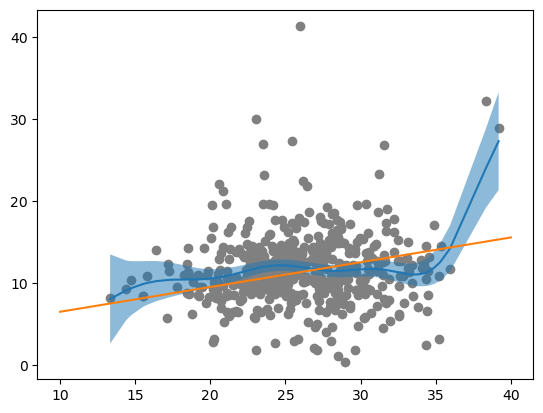

In [10]:
plt.scatter(V,Y, color = "grey")
inds = V.sort(0)[1][:,0]
plt.plot(V[inds],mu.detach()[inds])
plt.fill_between(V[inds][:,0],(mu - 2*cov.diag()**0.5)[inds].detach(),(mu + 2*cov.diag()**0.5)[inds].detach(), alpha = 0.5)
x = torch.linspace(10,40,100)
plt.plot(x,  3.476 + 0.302*x)

In [11]:
m,v = estimate_mean(dostatin),estimate_var(dostatin)

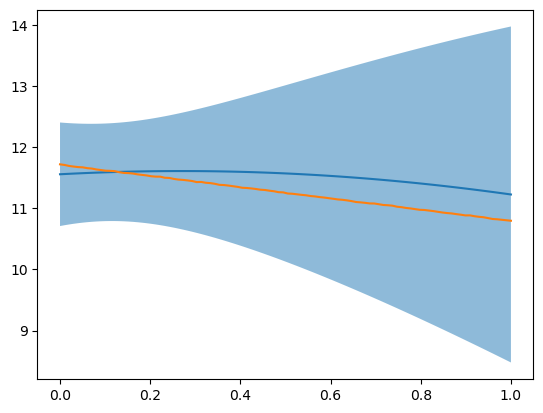

In [12]:
plt.plot(dostatin[:,None],m.detach())
plt.plot(dostatin,fvol.reshape(n_int,int_samples).mean(1));
plt.fill_between(dostatin, (m - v**0.5)[:,0], (m + v**0.5)[:,0], alpha = 0.5)

In [14]:
trials = 1
n_iter = 20
xi = 0.0
update_interval = 100
hyperparam_steps = 10
Y_train = torch.zeros((trials,n_iter+1))
for i in range(trials):
    
    # Instantiate the RBF kernel
    medheur = median_heuristic(statin[:,None].reshape(n_int,int_samples).mean(1)[:,None])
    rbf_kernel = GaussianKernel(lengthscale=torch.tensor([medheur]).requires_grad_(True), 
                                scale=torch.tensor([vol.var()**0.5]).requires_grad_(True))
    
    # Initialize the CausalKernel with the RBF base kernel
    causal_kernel = CausalKernel(
        estimate_mean_func=estimate_mean,
        estimate_var_func=estimate_var,
        base_kernel=rbf_kernel,
        add_base_kernel=True  # Set to False if you don't want to include the base kernel
    )
    
    # Define a grid of test points
    X_test = dostatin[:,None]
    
    # Precompute the grid of test outputs (Y_test)
    # Replace this with the actual true function or model to compute Y_test
    Y_test = fvol.reshape(n_int,int_samples).mean(1)[:,None]
    
    int_ = torch.randint(0,99,(1,))[0]
    
    # Run the CBO with no initial training data
    X_train, y_train = causal_bayesian_optimization(X_train=X_test[int_:int_+1,:], 
                                                    y_train=Y_test[int_:int_+1,:], 
                                                    kernel=causal_kernel, 
                                                    X_test=X_test, 
                                                    Y_test=Y_test, 
                                                    n_iter=n_iter, 
                                                    update_interval=update_interval,
                                                    xi = xi, 
                                                    print_ = True, 
                                                   minimise = True,
                                                   hyperparam_steps = hyperparam_steps,
                                                   noise_init = 0.0)
    Y_train[i] = y_train[:,0]

KeyboardInterrupt: 

In [ ]:
plt.fill_between(torch.linspace(0,len(Y_train.T)-1,len(Y_train.T)),
                 Y_train.mean(0) - Y_train.var(0)**0.5,
                 Y_train.mean(0) + Y_train.var(0)**0.5, alpha = 0.5)
plt.plot(Y_train.mean(0))

In [ ]:
# Instantiate the RBF kernel
rbf_kernel = GaussianKernel(lengthscale=torch.tensor([0.1]).requires_grad_(True), 
                            scale=torch.tensor([1.0]).requires_grad_(True))

# Initialize the CausalKernel with the RBF base kernel
causal_kernel = CausalKernel(
    estimate_mean_func=estimate_mean,
    estimate_var_func=estimate_var,
    base_kernel=rbf_kernel,
    add_base_kernel=True  # Set to False if you don't want to include the base kernel
)

# Define a grid of test points
X_test = dostatin[:,None]
Y_test = fvol.reshape(n_int,samples).mean(1)[:,None]

int_ = torch.randint(0,99,(1,))[0]


X_train=X_test[int_:int_+1,:]
y_train=Y_test[int_:int_+1,:]

gp = GaussianProcess(X_train=X_train, y_train=y_train, kernel=causal_kernel)

# Initialize the maximum observed value
y_max = -float('inf')

n_iter=2
update_hyperparameters=True
update_interval=100
hyperparam_steps=1
lr=0.01
xi = 0.1
minimise = True

In [ ]:
for i in range(n_iter):
        # Get the GP predictions for the test grid
        mu_s, cov_s = gp(X_test)
        sigma_s = torch.sqrt(torch.diag(cov_s))

        # Calculate the Expected Improvement
        ei = expected_improvement(mu_s[:,0], sigma_s, y_max, xi = xi, minimise = minimise)

        # Find the next best point
        next_index = torch.argmax(ei)
        next_x = X_test[next_index]
        next_y = Y_test[next_index]

        # Update the training data with the new point
        X_train = torch.cat((X_train, next_x.unsqueeze(0)), dim=0)
        y_train = torch.cat((y_train, next_y.unsqueeze(0)), dim=0)

        # Update GP model with new data
        gp.X_train = X_train
        gp.y_train = y_train

        # Perform hyperparameter optimization if required
        if update_hyperparameters and (i + 1) % update_interval == 0:
            gp.optimize_hyperparameters(num_steps=hyperparam_steps, lr=lr)

        # Update the best observed value
        y_max = torch.max(y_train)
        
        print(f"Iteration {i+1}: X = {next_x.item()}, Y = {next_y.item()}")
    
# Get the GP predictions for the test grid
mu_s, cov_s = gp(X_test)
sigma_s = torch.sqrt(torch.diag(cov_s))

# Calculate the Expected Improvement
ei = expected_improvement(mu_s[:,0], sigma_s, y_max, xi = xi, minimise = minimise)

fig,axs = plt.subplots(1,3,figsize = (15,5))
axs[0].scatter(X_train,y_train)
axs[0].plot(X_test,mu_s.detach())
axs[0].fill_between(X_test[:,0],(mu_s[:,0] - sigma_s).detach(),(mu_s[:,0] + sigma_s).detach(), alpha = 0.5)
axs[1].plot(X_test,ei)
axs[2].plot(y_train)